# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [3]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

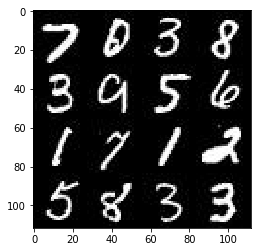

In [5]:
show_n_images = 16

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

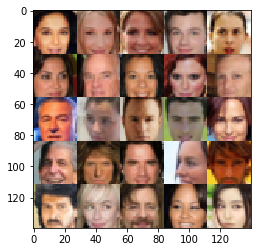

In [6]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [9]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_inputs')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='z_inputs')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [11]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.01
    with tf.variable_scope('discriminator', reuse=reuse):
                        
        h1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        h1 = tf.maximum(alpha * h1, h1)
        
        h2 = tf.layers.conv2d(h1, 128, 5, strides=2, padding='same')
        h2 = tf.layers.batch_normalization(h2, training=True)
        h2 = tf.maximum(alpha * h2, h2)
        
        h3 = tf.layers.conv2d(h2, 256, 5, strides=2, padding='same')
        h3 = tf.layers.batch_normalization(h3, training=True)
        h3 = tf.maximum(alpha * h3, h3)
        
        flat = tf.reshape(h3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [14]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.01
    with tf.variable_scope('generator', reuse=not is_train):
            
        h1 = tf.layers.dense(z, 2*2*512)
        h1 = tf.reshape(h1, (-1, 2, 2, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(alpha * h1, h1)
    
        h2 = tf.layers.conv2d_transpose(h1, 256, 5, 2, padding='valid')
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha * h2, h2)
    
        h3 = tf.layers.conv2d_transpose(h2, 128, 5, 2, padding='same')
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(alpha * h3, h3)
    
        logits = tf.layers.conv2d_transpose(h3, out_channel_dim, 5, 2, padding='same')
        out = tf.tanh(logits)
    
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [15]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [18]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    g_updates = [opt for opt in ops if opt.name.startswith('generator')]
    
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [19]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [27]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    losses = []
    steps = 0
    
    _,image_width,image_height,image_channels = data_shape
    
    inputs_real, inputs_z , learning_rate_pl = model_inputs(image_width,image_height,image_channels,z_dim)
    
    d_loss, g_loss = model_loss(inputs_real, inputs_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss,learning_rate_pl, beta1)
    
    n_images = 25
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                steps += 1
                
                batch_images *= 2.0
                               
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                sess.run(d_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, learning_rate_pl: learning_rate})
                sess.run(g_opt, feed_dict={inputs_real :batch_images, inputs_z: batch_z, learning_rate_pl:learning_rate})
                sess.run(g_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, learning_rate_pl:learning_rate})
                              
                if steps % 10 == 0 :
                    train_loss_d = d_loss.eval({inputs_real: batch_images, inputs_z: batch_z, learning_rate_pl:learning_rate})
                    train_loss_g = g_loss.eval({inputs_real: batch_images, inputs_z: batch_z, learning_rate_pl:learning_rate})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g))
                
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % 100 == 0:
                    show_generator_output(sess, n_images, inputs_z, image_channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 4.5229... Generator Loss: 0.3005
Epoch 1/2... Discriminator Loss: 2.0186... Generator Loss: 2.7307
Epoch 1/2... Discriminator Loss: 2.0845... Generator Loss: 2.9497
Epoch 1/2... Discriminator Loss: 1.6711... Generator Loss: 2.9616
Epoch 1/2... Discriminator Loss: 1.4896... Generator Loss: 2.3463
Epoch 1/2... Discriminator Loss: 1.0391... Generator Loss: 1.6205
Epoch 1/2... Discriminator Loss: 1.6475... Generator Loss: 2.7990
Epoch 1/2... Discriminator Loss: 1.3616... Generator Loss: 1.1683
Epoch 1/2... Discriminator Loss: 2.3154... Generator Loss: 0.1532
Epoch 1/2... Discriminator Loss: 1.4343... Generator Loss: 0.3929


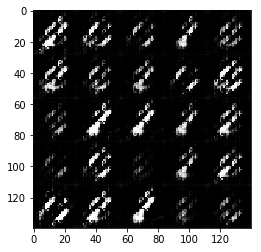

Epoch 1/2... Discriminator Loss: 1.5137... Generator Loss: 0.3685
Epoch 1/2... Discriminator Loss: 1.5813... Generator Loss: 0.3433
Epoch 1/2... Discriminator Loss: 1.7451... Generator Loss: 2.1769
Epoch 1/2... Discriminator Loss: 1.9353... Generator Loss: 2.8567
Epoch 1/2... Discriminator Loss: 1.4084... Generator Loss: 0.5025
Epoch 1/2... Discriminator Loss: 1.5740... Generator Loss: 0.4604
Epoch 1/2... Discriminator Loss: 1.2626... Generator Loss: 0.5162
Epoch 1/2... Discriminator Loss: 1.6945... Generator Loss: 0.3356
Epoch 1/2... Discriminator Loss: 1.5382... Generator Loss: 0.3689
Epoch 1/2... Discriminator Loss: 1.6895... Generator Loss: 0.3234


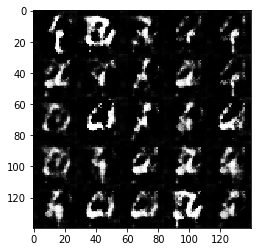

Epoch 1/2... Discriminator Loss: 1.5761... Generator Loss: 0.3913
Epoch 1/2... Discriminator Loss: 1.6989... Generator Loss: 0.3324
Epoch 1/2... Discriminator Loss: 1.3429... Generator Loss: 0.4893
Epoch 1/2... Discriminator Loss: 1.5777... Generator Loss: 0.3370
Epoch 1/2... Discriminator Loss: 1.3440... Generator Loss: 0.5276
Epoch 1/2... Discriminator Loss: 1.7643... Generator Loss: 0.3154
Epoch 1/2... Discriminator Loss: 1.4819... Generator Loss: 0.3829
Epoch 1/2... Discriminator Loss: 1.6192... Generator Loss: 0.3143
Epoch 1/2... Discriminator Loss: 1.3557... Generator Loss: 0.4740
Epoch 1/2... Discriminator Loss: 1.3263... Generator Loss: 0.5452


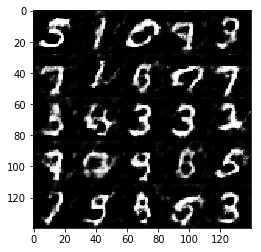

Epoch 1/2... Discriminator Loss: 1.3839... Generator Loss: 0.4992
Epoch 1/2... Discriminator Loss: 1.6138... Generator Loss: 0.3138
Epoch 1/2... Discriminator Loss: 1.6900... Generator Loss: 0.2989
Epoch 1/2... Discriminator Loss: 1.5300... Generator Loss: 0.3707
Epoch 1/2... Discriminator Loss: 1.7057... Generator Loss: 0.2826
Epoch 1/2... Discriminator Loss: 1.4858... Generator Loss: 0.4030
Epoch 1/2... Discriminator Loss: 1.5413... Generator Loss: 0.3576
Epoch 1/2... Discriminator Loss: 1.6363... Generator Loss: 0.3010
Epoch 1/2... Discriminator Loss: 1.5761... Generator Loss: 0.3315
Epoch 1/2... Discriminator Loss: 1.5375... Generator Loss: 0.3925


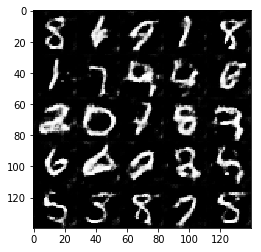

Epoch 1/2... Discriminator Loss: 1.3807... Generator Loss: 0.5088
Epoch 1/2... Discriminator Loss: 1.5574... Generator Loss: 0.3639
Epoch 1/2... Discriminator Loss: 1.5644... Generator Loss: 0.3603
Epoch 1/2... Discriminator Loss: 1.5515... Generator Loss: 0.3726
Epoch 1/2... Discriminator Loss: 1.5649... Generator Loss: 0.3653
Epoch 1/2... Discriminator Loss: 1.7084... Generator Loss: 0.2690
Epoch 2/2... Discriminator Loss: 1.7257... Generator Loss: 0.2654
Epoch 2/2... Discriminator Loss: 1.7863... Generator Loss: 0.2446
Epoch 2/2... Discriminator Loss: 1.5052... Generator Loss: 0.4219
Epoch 2/2... Discriminator Loss: 1.6047... Generator Loss: 0.3329


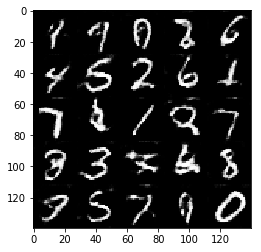

Epoch 2/2... Discriminator Loss: 1.4187... Generator Loss: 0.4822
Epoch 2/2... Discriminator Loss: 1.8013... Generator Loss: 0.2464
Epoch 2/2... Discriminator Loss: 1.6889... Generator Loss: 0.2784
Epoch 2/2... Discriminator Loss: 1.5820... Generator Loss: 0.3368
Epoch 2/2... Discriminator Loss: 1.5196... Generator Loss: 0.3759
Epoch 2/2... Discriminator Loss: 1.4610... Generator Loss: 0.5603
Epoch 2/2... Discriminator Loss: 1.4466... Generator Loss: 1.1127
Epoch 2/2... Discriminator Loss: 1.6576... Generator Loss: 1.3658
Epoch 2/2... Discriminator Loss: 1.4163... Generator Loss: 0.5839
Epoch 2/2... Discriminator Loss: 1.6090... Generator Loss: 0.3277


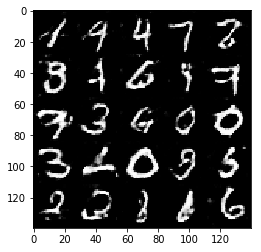

Epoch 2/2... Discriminator Loss: 1.5443... Generator Loss: 0.3511
Epoch 2/2... Discriminator Loss: 1.5266... Generator Loss: 0.3740
Epoch 2/2... Discriminator Loss: 1.6664... Generator Loss: 0.3058
Epoch 2/2... Discriminator Loss: 1.5399... Generator Loss: 0.3533
Epoch 2/2... Discriminator Loss: 1.5491... Generator Loss: 0.3945
Epoch 2/2... Discriminator Loss: 1.5497... Generator Loss: 0.3503
Epoch 2/2... Discriminator Loss: 1.6363... Generator Loss: 0.3085
Epoch 2/2... Discriminator Loss: 1.5776... Generator Loss: 0.3423
Epoch 2/2... Discriminator Loss: 1.3893... Generator Loss: 0.5508
Epoch 2/2... Discriminator Loss: 1.5512... Generator Loss: 0.4051


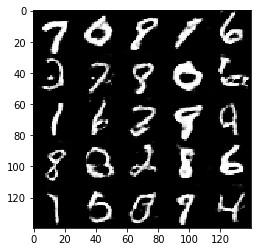

Epoch 2/2... Discriminator Loss: 1.5931... Generator Loss: 0.3512
Epoch 2/2... Discriminator Loss: 1.4893... Generator Loss: 0.4191
Epoch 2/2... Discriminator Loss: 1.3962... Generator Loss: 0.5226
Epoch 2/2... Discriminator Loss: 1.4755... Generator Loss: 0.4833
Epoch 2/2... Discriminator Loss: 1.5338... Generator Loss: 0.3888
Epoch 2/2... Discriminator Loss: 1.7107... Generator Loss: 0.3513
Epoch 2/2... Discriminator Loss: 1.4786... Generator Loss: 0.5048
Epoch 2/2... Discriminator Loss: 1.4479... Generator Loss: 0.6629
Epoch 2/2... Discriminator Loss: 1.3606... Generator Loss: 0.6756
Epoch 2/2... Discriminator Loss: 1.5955... Generator Loss: 0.3411


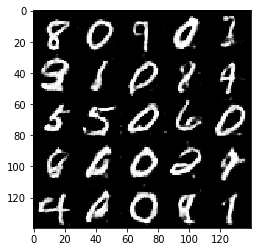

Epoch 2/2... Discriminator Loss: 1.4719... Generator Loss: 0.5094
Epoch 2/2... Discriminator Loss: 1.6758... Generator Loss: 0.2919
Epoch 2/2... Discriminator Loss: 1.3857... Generator Loss: 0.5581
Epoch 2/2... Discriminator Loss: 1.5907... Generator Loss: 0.3712
Epoch 2/2... Discriminator Loss: 1.4210... Generator Loss: 0.6906
Epoch 2/2... Discriminator Loss: 1.4138... Generator Loss: 0.7725
Epoch 2/2... Discriminator Loss: 1.4009... Generator Loss: 0.8213
Epoch 2/2... Discriminator Loss: 1.4477... Generator Loss: 0.9489
Epoch 2/2... Discriminator Loss: 1.4337... Generator Loss: 0.9279
Epoch 2/2... Discriminator Loss: 1.5673... Generator Loss: 0.7827


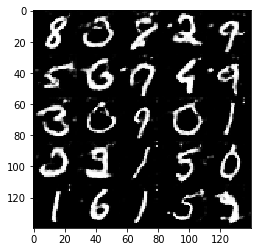

Epoch 2/2... Discriminator Loss: 1.4666... Generator Loss: 0.9937
Epoch 2/2... Discriminator Loss: 1.5157... Generator Loss: 0.9980
Epoch 2/2... Discriminator Loss: 1.5693... Generator Loss: 1.1046


In [28]:
batch_size = 128
z_dim = 100
learning_rate = 0.002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.8020... Generator Loss: 0.2464
Epoch 1/1... Discriminator Loss: 2.7893... Generator Loss: 0.1245
Epoch 1/1... Discriminator Loss: 3.0390... Generator Loss: 0.0968
Epoch 1/1... Discriminator Loss: 2.6315... Generator Loss: 0.2255
Epoch 1/1... Discriminator Loss: 1.1600... Generator Loss: 0.6811
Epoch 1/1... Discriminator Loss: 1.6903... Generator Loss: 0.4763
Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 0.6469
Epoch 1/1... Discriminator Loss: 1.8393... Generator Loss: 0.5419
Epoch 1/1... Discriminator Loss: 1.7068... Generator Loss: 0.7691
Epoch 1/1... Discriminator Loss: 1.8104... Generator Loss: 0.4811


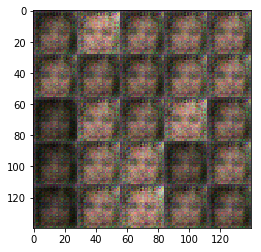

Epoch 1/1... Discriminator Loss: 1.8831... Generator Loss: 0.7184
Epoch 1/1... Discriminator Loss: 1.6828... Generator Loss: 0.5361
Epoch 1/1... Discriminator Loss: 1.5612... Generator Loss: 0.7801
Epoch 1/1... Discriminator Loss: 1.1607... Generator Loss: 0.8235
Epoch 1/1... Discriminator Loss: 1.7306... Generator Loss: 0.6163
Epoch 1/1... Discriminator Loss: 1.4873... Generator Loss: 0.7265
Epoch 1/1... Discriminator Loss: 1.5285... Generator Loss: 0.6036
Epoch 1/1... Discriminator Loss: 1.3998... Generator Loss: 0.8551
Epoch 1/1... Discriminator Loss: 1.2785... Generator Loss: 0.7922
Epoch 1/1... Discriminator Loss: 1.4659... Generator Loss: 0.6301


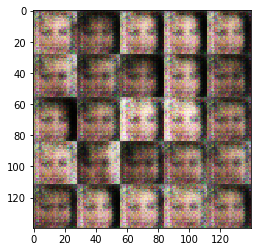

Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 0.6643
Epoch 1/1... Discriminator Loss: 1.5752... Generator Loss: 0.7317
Epoch 1/1... Discriminator Loss: 1.5128... Generator Loss: 0.6273
Epoch 1/1... Discriminator Loss: 1.6855... Generator Loss: 0.5097
Epoch 1/1... Discriminator Loss: 1.5363... Generator Loss: 0.6848
Epoch 1/1... Discriminator Loss: 1.6101... Generator Loss: 0.6177
Epoch 1/1... Discriminator Loss: 1.4331... Generator Loss: 0.6406
Epoch 1/1... Discriminator Loss: 1.4381... Generator Loss: 0.5977
Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 0.6915
Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.6195


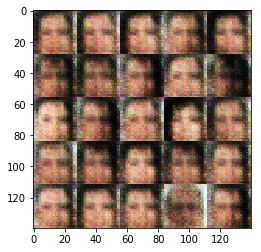

Epoch 1/1... Discriminator Loss: 1.3920... Generator Loss: 0.7818
Epoch 1/1... Discriminator Loss: 1.3467... Generator Loss: 0.7230
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.6441
Epoch 1/1... Discriminator Loss: 1.3599... Generator Loss: 0.6591
Epoch 1/1... Discriminator Loss: 1.4519... Generator Loss: 0.5777
Epoch 1/1... Discriminator Loss: 1.4556... Generator Loss: 0.5901
Epoch 1/1... Discriminator Loss: 1.5171... Generator Loss: 0.5502
Epoch 1/1... Discriminator Loss: 1.4515... Generator Loss: 0.6754
Epoch 1/1... Discriminator Loss: 1.3661... Generator Loss: 0.7464
Epoch 1/1... Discriminator Loss: 1.4695... Generator Loss: 0.7198


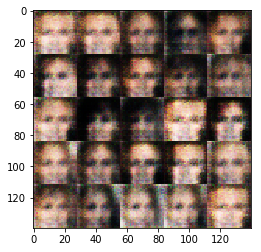

Epoch 1/1... Discriminator Loss: 1.4499... Generator Loss: 0.6339
Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.6907
Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 0.5598
Epoch 1/1... Discriminator Loss: 1.4498... Generator Loss: 0.6829
Epoch 1/1... Discriminator Loss: 1.5300... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.5294... Generator Loss: 0.7078
Epoch 1/1... Discriminator Loss: 1.5616... Generator Loss: 0.6759
Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 0.7571
Epoch 1/1... Discriminator Loss: 1.4079... Generator Loss: 0.7003
Epoch 1/1... Discriminator Loss: 1.3189... Generator Loss: 0.7207


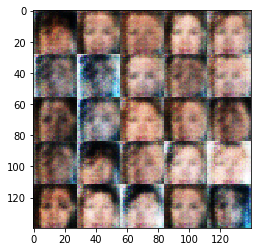

Epoch 1/1... Discriminator Loss: 1.4496... Generator Loss: 0.6292
Epoch 1/1... Discriminator Loss: 1.4588... Generator Loss: 0.6139
Epoch 1/1... Discriminator Loss: 1.4111... Generator Loss: 0.5474
Epoch 1/1... Discriminator Loss: 1.4832... Generator Loss: 0.5957
Epoch 1/1... Discriminator Loss: 1.5288... Generator Loss: 0.5465
Epoch 1/1... Discriminator Loss: 1.4588... Generator Loss: 0.7141
Epoch 1/1... Discriminator Loss: 1.4523... Generator Loss: 0.7425
Epoch 1/1... Discriminator Loss: 1.5152... Generator Loss: 0.5979
Epoch 1/1... Discriminator Loss: 1.4417... Generator Loss: 0.7600
Epoch 1/1... Discriminator Loss: 1.4206... Generator Loss: 0.7054


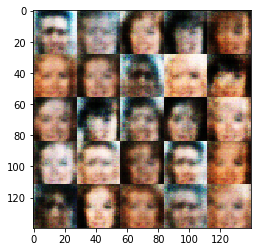

Epoch 1/1... Discriminator Loss: 1.5362... Generator Loss: 0.5190
Epoch 1/1... Discriminator Loss: 1.4738... Generator Loss: 0.5585
Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.5809
Epoch 1/1... Discriminator Loss: 1.4968... Generator Loss: 0.6286
Epoch 1/1... Discriminator Loss: 1.4843... Generator Loss: 0.5892
Epoch 1/1... Discriminator Loss: 1.4547... Generator Loss: 0.5451
Epoch 1/1... Discriminator Loss: 1.4814... Generator Loss: 0.5243
Epoch 1/1... Discriminator Loss: 1.4051... Generator Loss: 0.6283
Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 0.7004
Epoch 1/1... Discriminator Loss: 1.5124... Generator Loss: 0.7560


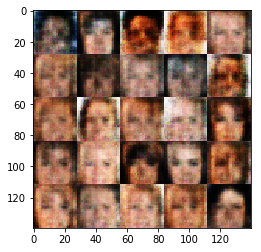

Epoch 1/1... Discriminator Loss: 1.4665... Generator Loss: 0.6512
Epoch 1/1... Discriminator Loss: 1.4545... Generator Loss: 0.5977
Epoch 1/1... Discriminator Loss: 1.5022... Generator Loss: 0.5451
Epoch 1/1... Discriminator Loss: 1.4575... Generator Loss: 0.6809
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.6564
Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 0.6310
Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.6870
Epoch 1/1... Discriminator Loss: 1.4412... Generator Loss: 0.6595
Epoch 1/1... Discriminator Loss: 1.4217... Generator Loss: 0.6300
Epoch 1/1... Discriminator Loss: 1.4241... Generator Loss: 0.6236


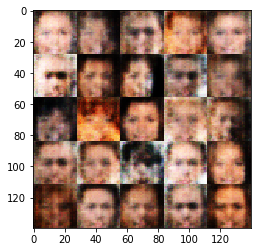

Epoch 1/1... Discriminator Loss: 1.5053... Generator Loss: 0.5742
Epoch 1/1... Discriminator Loss: 1.4770... Generator Loss: 0.6856
Epoch 1/1... Discriminator Loss: 1.4358... Generator Loss: 0.6985
Epoch 1/1... Discriminator Loss: 1.4711... Generator Loss: 0.5672
Epoch 1/1... Discriminator Loss: 1.4741... Generator Loss: 0.7223
Epoch 1/1... Discriminator Loss: 1.4635... Generator Loss: 0.5829
Epoch 1/1... Discriminator Loss: 1.4883... Generator Loss: 0.6308
Epoch 1/1... Discriminator Loss: 1.4644... Generator Loss: 0.6865
Epoch 1/1... Discriminator Loss: 1.4181... Generator Loss: 0.7030
Epoch 1/1... Discriminator Loss: 1.4459... Generator Loss: 0.6821


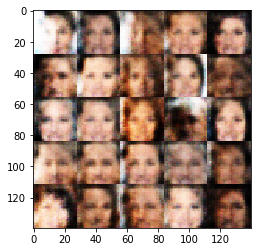

Epoch 1/1... Discriminator Loss: 1.4183... Generator Loss: 0.7248
Epoch 1/1... Discriminator Loss: 1.4168... Generator Loss: 0.6740
Epoch 1/1... Discriminator Loss: 1.5088... Generator Loss: 0.6875
Epoch 1/1... Discriminator Loss: 1.4210... Generator Loss: 0.6485
Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 0.6237
Epoch 1/1... Discriminator Loss: 1.4158... Generator Loss: 0.6270
Epoch 1/1... Discriminator Loss: 1.4469... Generator Loss: 0.5374
Epoch 1/1... Discriminator Loss: 1.4215... Generator Loss: 0.6825
Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.6347
Epoch 1/1... Discriminator Loss: 1.4328... Generator Loss: 0.6671


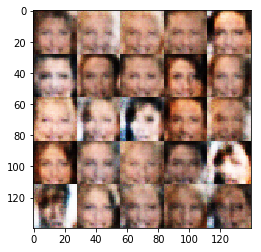

Epoch 1/1... Discriminator Loss: 1.4451... Generator Loss: 0.6732
Epoch 1/1... Discriminator Loss: 1.4738... Generator Loss: 0.6119
Epoch 1/1... Discriminator Loss: 1.4644... Generator Loss: 0.5653
Epoch 1/1... Discriminator Loss: 1.4162... Generator Loss: 0.6182
Epoch 1/1... Discriminator Loss: 1.4349... Generator Loss: 0.6012
Epoch 1/1... Discriminator Loss: 1.4110... Generator Loss: 0.6956
Epoch 1/1... Discriminator Loss: 1.4373... Generator Loss: 0.6131
Epoch 1/1... Discriminator Loss: 1.4351... Generator Loss: 0.6454
Epoch 1/1... Discriminator Loss: 1.4714... Generator Loss: 0.5875
Epoch 1/1... Discriminator Loss: 1.4981... Generator Loss: 0.5708


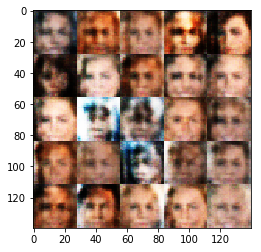

Epoch 1/1... Discriminator Loss: 1.4473... Generator Loss: 0.5597
Epoch 1/1... Discriminator Loss: 1.3998... Generator Loss: 0.7536
Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.7138
Epoch 1/1... Discriminator Loss: 1.4407... Generator Loss: 0.6446
Epoch 1/1... Discriminator Loss: 1.4620... Generator Loss: 0.7347
Epoch 1/1... Discriminator Loss: 1.4287... Generator Loss: 0.5683
Epoch 1/1... Discriminator Loss: 1.4386... Generator Loss: 0.6026
Epoch 1/1... Discriminator Loss: 1.4182... Generator Loss: 0.6829
Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 0.7521
Epoch 1/1... Discriminator Loss: 1.4503... Generator Loss: 0.6407


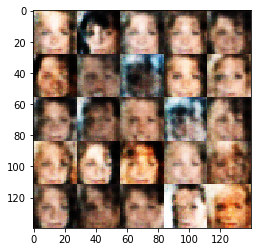

Epoch 1/1... Discriminator Loss: 1.4749... Generator Loss: 0.6913
Epoch 1/1... Discriminator Loss: 1.4461... Generator Loss: 0.6144
Epoch 1/1... Discriminator Loss: 1.3853... Generator Loss: 0.6064
Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.6408
Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.7183
Epoch 1/1... Discriminator Loss: 1.4304... Generator Loss: 0.5769
Epoch 1/1... Discriminator Loss: 1.4475... Generator Loss: 0.5865
Epoch 1/1... Discriminator Loss: 1.4322... Generator Loss: 0.6489
Epoch 1/1... Discriminator Loss: 1.4367... Generator Loss: 0.7397
Epoch 1/1... Discriminator Loss: 1.4630... Generator Loss: 0.5648


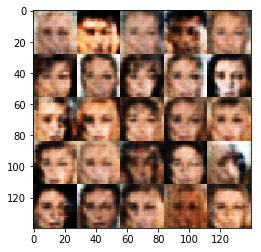

Epoch 1/1... Discriminator Loss: 1.4600... Generator Loss: 0.7039
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.6650
Epoch 1/1... Discriminator Loss: 1.4452... Generator Loss: 0.6313
Epoch 1/1... Discriminator Loss: 1.4009... Generator Loss: 0.7917
Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.6580
Epoch 1/1... Discriminator Loss: 1.4457... Generator Loss: 0.6105
Epoch 1/1... Discriminator Loss: 1.4512... Generator Loss: 0.6317
Epoch 1/1... Discriminator Loss: 1.4299... Generator Loss: 0.7209
Epoch 1/1... Discriminator Loss: 1.4255... Generator Loss: 0.6470
Epoch 1/1... Discriminator Loss: 1.4506... Generator Loss: 0.6574


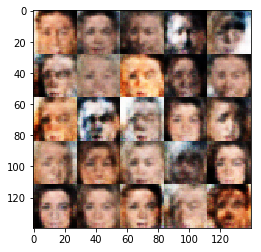

Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 0.7114
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.7225
Epoch 1/1... Discriminator Loss: 1.4417... Generator Loss: 0.6037
Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 0.6558
Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 0.6831
Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.6855
Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 0.6215
Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 0.6703
Epoch 1/1... Discriminator Loss: 1.4302... Generator Loss: 0.7438
Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.6823


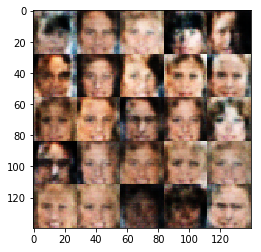

Epoch 1/1... Discriminator Loss: 1.4468... Generator Loss: 0.6567
Epoch 1/1... Discriminator Loss: 1.4483... Generator Loss: 0.7091
Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 0.7129
Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 0.7183
Epoch 1/1... Discriminator Loss: 1.4897... Generator Loss: 0.5693
Epoch 1/1... Discriminator Loss: 1.4161... Generator Loss: 0.6345
Epoch 1/1... Discriminator Loss: 1.4218... Generator Loss: 0.6325
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.7621
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.6651
Epoch 1/1... Discriminator Loss: 1.4202... Generator Loss: 0.6717


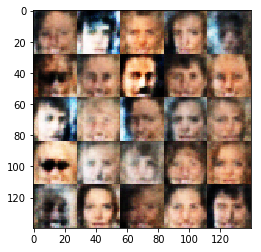

Epoch 1/1... Discriminator Loss: 1.4633... Generator Loss: 0.7231
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.6740
Epoch 1/1... Discriminator Loss: 1.4403... Generator Loss: 0.6475
Epoch 1/1... Discriminator Loss: 1.4251... Generator Loss: 0.6238
Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.7289
Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 0.6988
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.7161
Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.6515
Epoch 1/1... Discriminator Loss: 1.3998... Generator Loss: 0.7027
Epoch 1/1... Discriminator Loss: 1.4493... Generator Loss: 0.6744


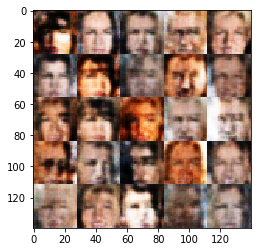

Epoch 1/1... Discriminator Loss: 1.4293... Generator Loss: 0.7022
Epoch 1/1... Discriminator Loss: 1.4224... Generator Loss: 0.6096
Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.6476
Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.6588
Epoch 1/1... Discriminator Loss: 1.3951... Generator Loss: 0.6258
Epoch 1/1... Discriminator Loss: 1.4709... Generator Loss: 0.6161
Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 0.6783
Epoch 1/1... Discriminator Loss: 1.4407... Generator Loss: 0.6089
Epoch 1/1... Discriminator Loss: 1.4287... Generator Loss: 0.6554
Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.7123


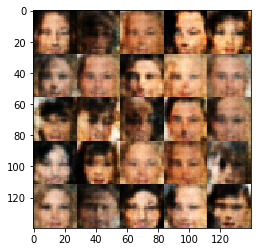

Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.6787
Epoch 1/1... Discriminator Loss: 1.4400... Generator Loss: 0.6993
Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.7356
Epoch 1/1... Discriminator Loss: 1.4310... Generator Loss: 0.6429
Epoch 1/1... Discriminator Loss: 1.4394... Generator Loss: 0.6228
Epoch 1/1... Discriminator Loss: 1.4712... Generator Loss: 0.6376
Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.6838
Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 0.6626
Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.5951


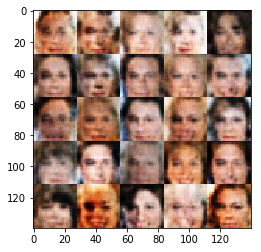

Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.6610
Epoch 1/1... Discriminator Loss: 1.4089... Generator Loss: 0.6523
Epoch 1/1... Discriminator Loss: 1.4254... Generator Loss: 0.6257
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.6912
Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 0.6370
Epoch 1/1... Discriminator Loss: 1.4540... Generator Loss: 0.7050
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.6622
Epoch 1/1... Discriminator Loss: 1.4417... Generator Loss: 0.5876
Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.6444
Epoch 1/1... Discriminator Loss: 1.4310... Generator Loss: 0.5599


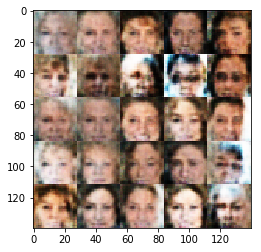

Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 0.7316
Epoch 1/1... Discriminator Loss: 1.4182... Generator Loss: 0.6910
Epoch 1/1... Discriminator Loss: 1.4258... Generator Loss: 0.6437
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.6987
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.6372
Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 0.6511
Epoch 1/1... Discriminator Loss: 1.4183... Generator Loss: 0.6436
Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.8142
Epoch 1/1... Discriminator Loss: 1.4223... Generator Loss: 0.6358
Epoch 1/1... Discriminator Loss: 1.4241... Generator Loss: 0.5876


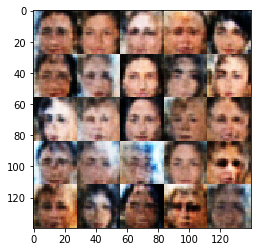

Epoch 1/1... Discriminator Loss: 1.4281... Generator Loss: 0.6571
Epoch 1/1... Discriminator Loss: 1.4436... Generator Loss: 0.6970
Epoch 1/1... Discriminator Loss: 1.4316... Generator Loss: 0.7135
Epoch 1/1... Discriminator Loss: 1.4058... Generator Loss: 0.6827
Epoch 1/1... Discriminator Loss: 1.4284... Generator Loss: 0.6288
Epoch 1/1... Discriminator Loss: 1.4219... Generator Loss: 0.6754
Epoch 1/1... Discriminator Loss: 1.4412... Generator Loss: 0.6297
Epoch 1/1... Discriminator Loss: 1.4504... Generator Loss: 0.6137
Epoch 1/1... Discriminator Loss: 1.4370... Generator Loss: 0.6508
Epoch 1/1... Discriminator Loss: 1.4501... Generator Loss: 0.6203


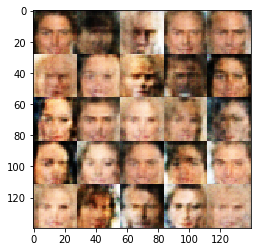

Epoch 1/1... Discriminator Loss: 1.4925... Generator Loss: 0.7273
Epoch 1/1... Discriminator Loss: 1.4429... Generator Loss: 0.6871
Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.6655
Epoch 1/1... Discriminator Loss: 1.4104... Generator Loss: 0.7144
Epoch 1/1... Discriminator Loss: 1.4110... Generator Loss: 0.6758
Epoch 1/1... Discriminator Loss: 1.4603... Generator Loss: 0.6128
Epoch 1/1... Discriminator Loss: 1.4282... Generator Loss: 0.6644
Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 0.7046
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.7326
Epoch 1/1... Discriminator Loss: 1.4271... Generator Loss: 0.6613


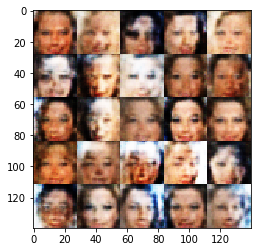

Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.6362
Epoch 1/1... Discriminator Loss: 1.4351... Generator Loss: 0.6362
Epoch 1/1... Discriminator Loss: 1.4359... Generator Loss: 0.6251
Epoch 1/1... Discriminator Loss: 1.4392... Generator Loss: 0.6877
Epoch 1/1... Discriminator Loss: 1.4104... Generator Loss: 0.7454
Epoch 1/1... Discriminator Loss: 1.4099... Generator Loss: 0.6629
Epoch 1/1... Discriminator Loss: 1.4229... Generator Loss: 0.6118
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.6261
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.6803
Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 0.6293


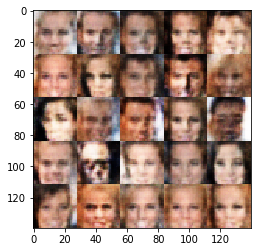

Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 0.6412
Epoch 1/1... Discriminator Loss: 1.4342... Generator Loss: 0.6634
Epoch 1/1... Discriminator Loss: 1.4373... Generator Loss: 0.6472
Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.6650
Epoch 1/1... Discriminator Loss: 1.4469... Generator Loss: 0.6141
Epoch 1/1... Discriminator Loss: 1.4304... Generator Loss: 0.5705
Epoch 1/1... Discriminator Loss: 1.4148... Generator Loss: 0.6974
Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 0.6655
Epoch 1/1... Discriminator Loss: 1.4312... Generator Loss: 0.7090
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.7884


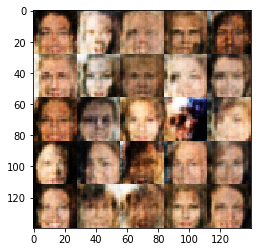

Epoch 1/1... Discriminator Loss: 1.4353... Generator Loss: 0.6071
Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.7195
Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.7128
Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.7194
Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.6903
Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.7104
Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.6249
Epoch 1/1... Discriminator Loss: 1.4453... Generator Loss: 0.7357
Epoch 1/1... Discriminator Loss: 1.4385... Generator Loss: 0.6618
Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 0.6047


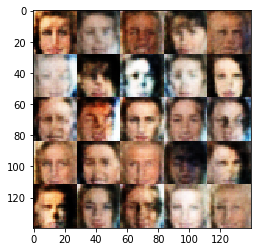

Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.6808
Epoch 1/1... Discriminator Loss: 1.4122... Generator Loss: 0.6521
Epoch 1/1... Discriminator Loss: 1.4221... Generator Loss: 0.6463
Epoch 1/1... Discriminator Loss: 1.4089... Generator Loss: 0.6711
Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.6619
Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.6725
Epoch 1/1... Discriminator Loss: 1.4240... Generator Loss: 0.6753
Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 0.7310
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.6389
Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.6248


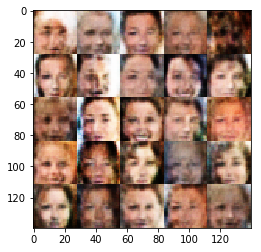

Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.6818
Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 0.6830
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.6844
Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.6456
Epoch 1/1... Discriminator Loss: 1.4223... Generator Loss: 0.6367
Epoch 1/1... Discriminator Loss: 1.4268... Generator Loss: 0.6772
Epoch 1/1... Discriminator Loss: 1.4098... Generator Loss: 0.6237
Epoch 1/1... Discriminator Loss: 1.4095... Generator Loss: 0.6553
Epoch 1/1... Discriminator Loss: 1.4288... Generator Loss: 0.6237
Epoch 1/1... Discriminator Loss: 1.4007... Generator Loss: 0.7109


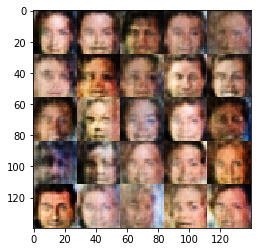

Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.6558
Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 0.7375
Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.7776
Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 0.7190
Epoch 1/1... Discriminator Loss: 1.4162... Generator Loss: 0.6120
Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.6328
Epoch 1/1... Discriminator Loss: 1.4204... Generator Loss: 0.7035
Epoch 1/1... Discriminator Loss: 1.4108... Generator Loss: 0.6807
Epoch 1/1... Discriminator Loss: 1.4161... Generator Loss: 0.6376
Epoch 1/1... Discriminator Loss: 1.4237... Generator Loss: 0.7279


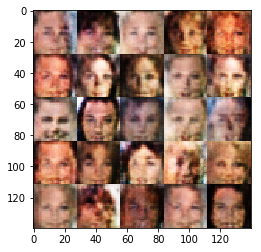

Epoch 1/1... Discriminator Loss: 1.4212... Generator Loss: 0.6368
Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.6344
Epoch 1/1... Discriminator Loss: 1.4073... Generator Loss: 0.7009
Epoch 1/1... Discriminator Loss: 1.4360... Generator Loss: 0.6608
Epoch 1/1... Discriminator Loss: 1.4300... Generator Loss: 0.6770
Epoch 1/1... Discriminator Loss: 1.4286... Generator Loss: 0.6433
Epoch 1/1... Discriminator Loss: 1.3948... Generator Loss: 0.6790
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.7126
Epoch 1/1... Discriminator Loss: 1.4368... Generator Loss: 0.6213
Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 0.6292


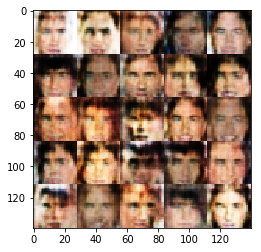

Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.6288
Epoch 1/1... Discriminator Loss: 1.4192... Generator Loss: 0.6638
Epoch 1/1... Discriminator Loss: 1.4195... Generator Loss: 0.6856
Epoch 1/1... Discriminator Loss: 1.4218... Generator Loss: 0.6670
Epoch 1/1... Discriminator Loss: 1.4399... Generator Loss: 0.6648
Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.7655
Epoch 1/1... Discriminator Loss: 1.4185... Generator Loss: 0.6664
Epoch 1/1... Discriminator Loss: 1.4269... Generator Loss: 0.6103
Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.6628
Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.7075


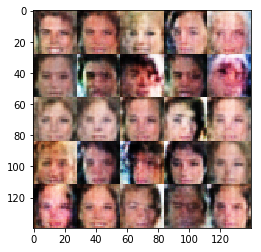

Epoch 1/1... Discriminator Loss: 1.4130... Generator Loss: 0.6751
Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 0.6519
Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.6970
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.6587
Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 0.6840
Epoch 1/1... Discriminator Loss: 1.4325... Generator Loss: 0.6594


In [30]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.